In [222]:
import torch 
from models.resnet_model import resnet8
from models.resnet_model import resnet20

In [158]:
import sys
sys.path.append("/mnt/data/th")
from FedML.fedml_api.data_preprocessing.cifar10.data_loader import get_client_idxes_dict, get_client_dataloader

In [185]:
train_dl_all,test_dl = get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar10", 64, {}, client_idx=None, train=False)

In [160]:
from sklearn.metrics import classification_report
import numpy

In [174]:
model  = resnet8(10)

paras_old = model.state_dict()
# print(len(.keys()))
paras = torch.load("/mnt/data/th/FedAlign/logs/20221010_042844__fedprox_e10_c100/server.pt")

for key,value in zip(list(paras_old.keys()),list(paras.values())):
    paras_old[key] = value

model.load_state_dict(paras_old)
device = torch.device("cuda")
model.to(device)
model.eval()

preds = None
labels = None
logits_list = [[] for x in range(10)] 
# print(logits_list)

with torch.no_grad():
    for x,y in test_dl:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)

        probs = torch.softmax(logits,dim=1)

        maxlogits,preds_inner = torch.max(probs,dim=1)

        if preds is None:
            preds = preds_inner.cpu()
            labels = y.cpu()
        else:
            preds = numpy.concatenate((preds,preds_inner.cpu()))
            labels = numpy.concatenate((labels,y.cpu()))
        for logit,pred,label in zip(maxlogits.cpu()**2,preds_inner.cpu(),y.cpu()):
            if pred == label:
                logits_list[pred].append(logit.data)
   
res = classification_report(labels,preds,output_dict = True)
for index,class_list in enumerate(logits_list):
    confidence_class = numpy.array(class_list).mean()
    res[str(index)].update({"confidence":confidence_class})
    # confidence.append(confidence_class)

import pandas

data_df = pandas.DataFrame(res).T

data_df = data_df.drop("accuracy").drop("macro avg").drop("weighted avg")

data_df["diff"] = data_df["confidence"]-data_df["precision"]
print(data_df)
# data_df["diff"] = data_df["diff"].abs()

   precision    recall  f1-score  support  confidence      diff
0   0.609278  0.592184  0.600610    998.0    0.506604 -0.102675
1   0.703191  0.661662  0.681795    999.0    0.504125 -0.199067
2   0.657993  0.177177  0.279180    999.0    0.295754 -0.362239
3   0.396070  0.525577  0.451724    997.0    0.316280 -0.079789
4   0.425843  0.669000  0.520420   1000.0    0.490622  0.064778
5   0.534504  0.427282  0.474916    997.0    0.395710 -0.138794
6   0.591673  0.739000  0.657181   1000.0    0.625297  0.033623
7   0.711842  0.542628  0.615822    997.0    0.502943 -0.208899
8   0.597896  0.741224  0.661890    997.0    0.565876 -0.032020
9   0.689298  0.599000  0.640984   1000.0    0.454619 -0.234679


### MOON Train

In [ ]:
model  = resnet8(10,KD=True,projection=True)

paras_old = model.state_dict()
# print(len(.keys()))
paras = torch.load("/mnt/data/th/FedAlign/logs/20221010_100211__moon_e10_c100/server.pt")

for key,value in zip(list(paras_old.keys()),list(paras.values())):
    paras_old[key] = value

model.load_state_dict(paras_old)
device = torch.device("cuda")
model.to(device)
model.eval()

preds = None
labels = None
logits_list = [[] for x in range(10)] 
# print(logits_list)

with torch.no_grad():
    for x,y in test_dl:
        x = x.to(device)
        y = y.to(device)
        _,logits = model(x)

        probs = torch.softmax(logits,dim=1)

        maxlogits,preds_inner = torch.max(probs,dim=1)

        if preds is None:
            preds = preds_inner.cpu()
            labels = y.cpu()
        else:
            preds = numpy.concatenate((preds,preds_inner.cpu()))
            labels = numpy.concatenate((labels,y.cpu()))
        for logit,pred,label in zip(maxlogits.cpu()**2,preds_inner.cpu(),y.cpu()):
            if pred == label:
                logits_list[pred].append(logit.data)
   
res = classification_report(labels,preds,output_dict = True)
for index,class_list in enumerate(logits_list):
    confidence_class = numpy.array(class_list).mean()
    res[str(index)].update({"confidence":confidence_class})
    # confidence.append(confidence_class)

import pandas

data_df = pandas.DataFrame(res).T

data_df = data_df.drop("accuracy").drop("macro avg").drop("weighted avg")

data_df["diff"] = data_df["confidence"]-data_df["precision"]
print(data_df)
# data_df["diff"] = data_df["diff"].abs()

### FedRS

In [170]:
model  = resnet8(10,KD=True)

paras_old = model.state_dict()
# print(len(.keys()))
paras = torch.load("/mnt/data/th/FedAlign/logs/20221010_013310__fedrs_e10_c100/server.pt")

for key,value in zip(list(paras_old.keys()),list(paras.values())):
    paras_old[key] = value

model.load_state_dict(paras_old)
device = torch.device("cuda")
model.to(device)
model.eval()

preds = None
labels = None
logits_list = [[] for x in range(10)] 
# print(logits_list)

with torch.no_grad():
    for x,y in test_dl:
        x = x.to(device)
        y = y.to(device)

        hs,_ = model(x)
        ws = model.fc.weight

        logits = hs.mm(ws.transpose(0, 1))

        probs = torch.softmax(logits,dim=1)

        maxlogits,preds_inner = torch.max(probs,dim=1)

        if preds is None:
            preds = preds_inner.cpu()
            labels = y.cpu()
        else:
            preds = numpy.concatenate((preds,preds_inner.cpu()))
            labels = numpy.concatenate((labels,y.cpu()))
        for logit,pred,label in zip(maxlogits.cpu()**2,preds_inner.cpu(),y.cpu()):
            if pred == label:
                logits_list[pred].append(logit.data)
   
res = classification_report(labels,preds,output_dict = True)
for index,class_list in enumerate(logits_list):
    confidence_class = numpy.array(class_list).mean()
    res[str(index)].update({"confidence":confidence_class})
    # confidence.append(confidence_class)

import pandas

data_df = pandas.DataFrame(res).T

data_df = data_df.drop("accuracy").drop("macro avg").drop("weighted avg")

data_df["diff"] = data_df["confidence"]-data_df["precision"]
print(data_df)
# data_df["diff"] = data_df["diff"].abs()

   precision    recall  f1-score  support  confidence      diff
0   0.695652  0.609218  0.649573    998.0    0.858760  0.163108
1   0.488164  0.928929  0.640000    999.0    0.974200  0.486036
2   0.567026  0.368368  0.446602    999.0    0.800342  0.233316
3   0.423901  0.377131  0.399151    997.0    0.651671  0.227770
4   0.483757  0.685000  0.567053   1000.0    0.899602  0.415845
5   0.465551  0.725176  0.567059    997.0    0.876786  0.411235
6   0.665039  0.681000  0.672925   1000.0    0.922921  0.257882
7   0.811550  0.535607  0.645317    997.0    0.863250  0.051700
8   0.823856  0.595787  0.691502    997.0    0.828865  0.005009
9   0.903654  0.272000  0.418140   1000.0    0.716106 -0.187548


#### Ensemble Model

   precision    recall  f1-score  support  confidence      diff
0   0.764877  0.528056  0.624778    998.0    0.606713 -0.158164
1   0.809426  0.790791  0.800000    999.0    0.744608 -0.064818
2   0.477557  0.649650  0.550466    999.0    0.650773  0.173216
3   0.524709  0.362086  0.428487    997.0    0.414882 -0.109828
4   0.598104  0.631000  0.614112   1000.0    0.620123  0.022019
5   0.564570  0.684052  0.618594    997.0    0.611324  0.046755
6   0.762188  0.641000  0.696361   1000.0    0.653439 -0.108748
7   0.665746  0.725176  0.694191    997.0    0.751480  0.085735
8   0.771107  0.824473  0.796898    997.0    0.792158  0.021052
9   0.776575  0.789000  0.782738   1000.0    0.784697  0.008122
0.0798455277077069


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


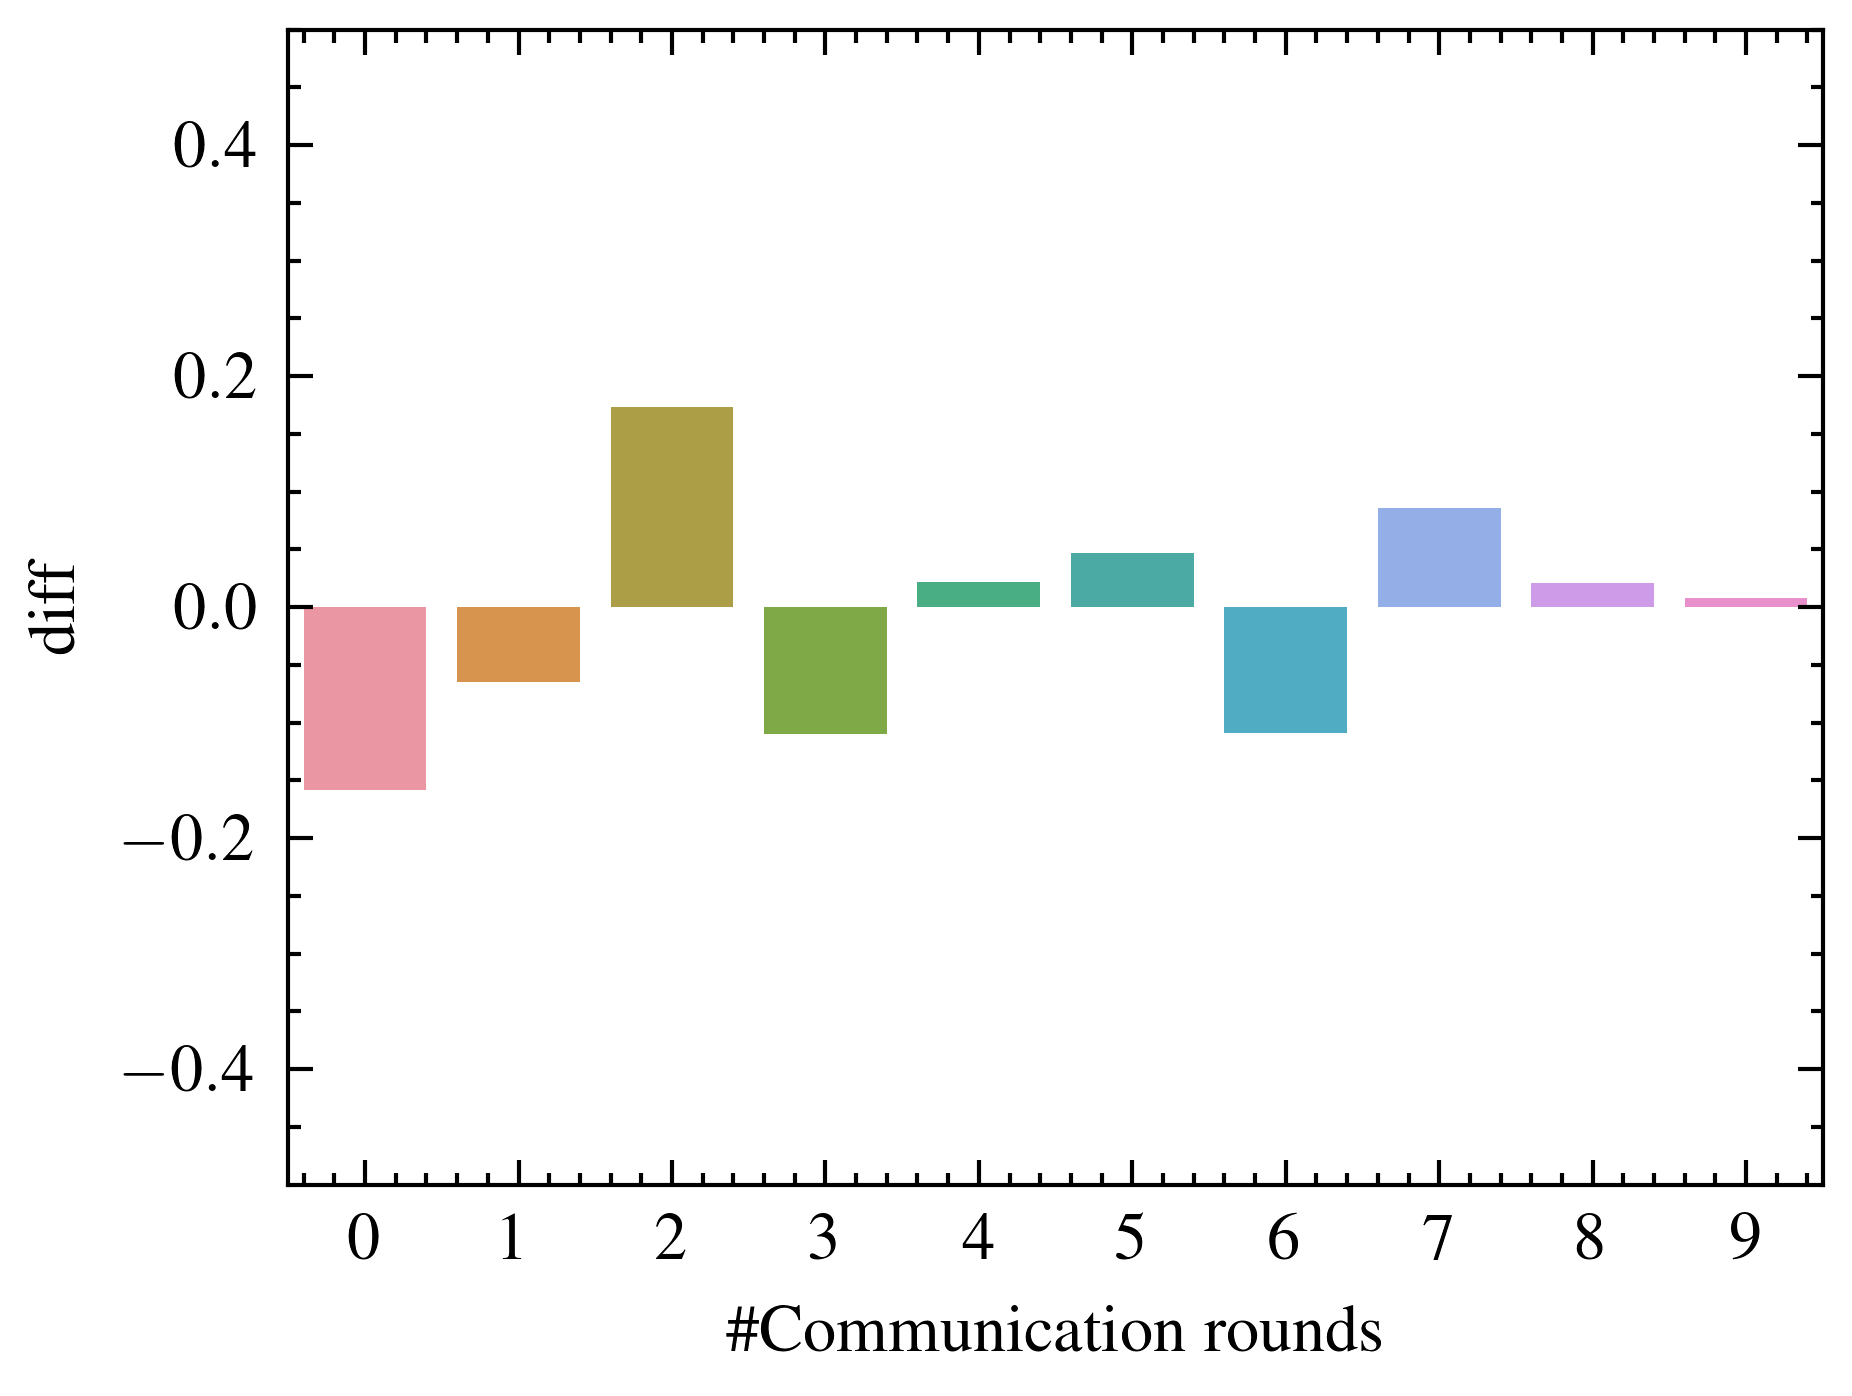

In [165]:
print(data_df)
print(data_df["diff"].abs().mean())

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
sns.barplot(x = data_df.index, y = "diff",data = data_df)
plt.ylim(-0.5,0.5)
plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

#### FedAvg

##### TestDl

   precision    recall  f1-score  support  confidence      diff
0   0.719888  0.515030  0.600467    998.0    0.473416 -0.246472
1   0.857708  0.651652  0.740614    999.0    0.532631 -0.325076
2   0.431667  0.518519  0.471123    999.0    0.508201  0.076535
3   0.600509  0.236710  0.339568    997.0    0.231427 -0.369082
4   0.412690  0.761000  0.535162   1000.0    0.571366  0.158676
5   0.580454  0.589769  0.585075    997.0    0.396272 -0.184183
6   0.671518  0.646000  0.658512   1000.0    0.525829 -0.145688
7   0.678832  0.652959  0.665644    997.0    0.562441 -0.116391
8   0.729831  0.780341  0.754241    997.0    0.634907 -0.094924
9   0.734637  0.789000  0.760849   1000.0    0.574731 -0.159906
0.1876932123973909


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


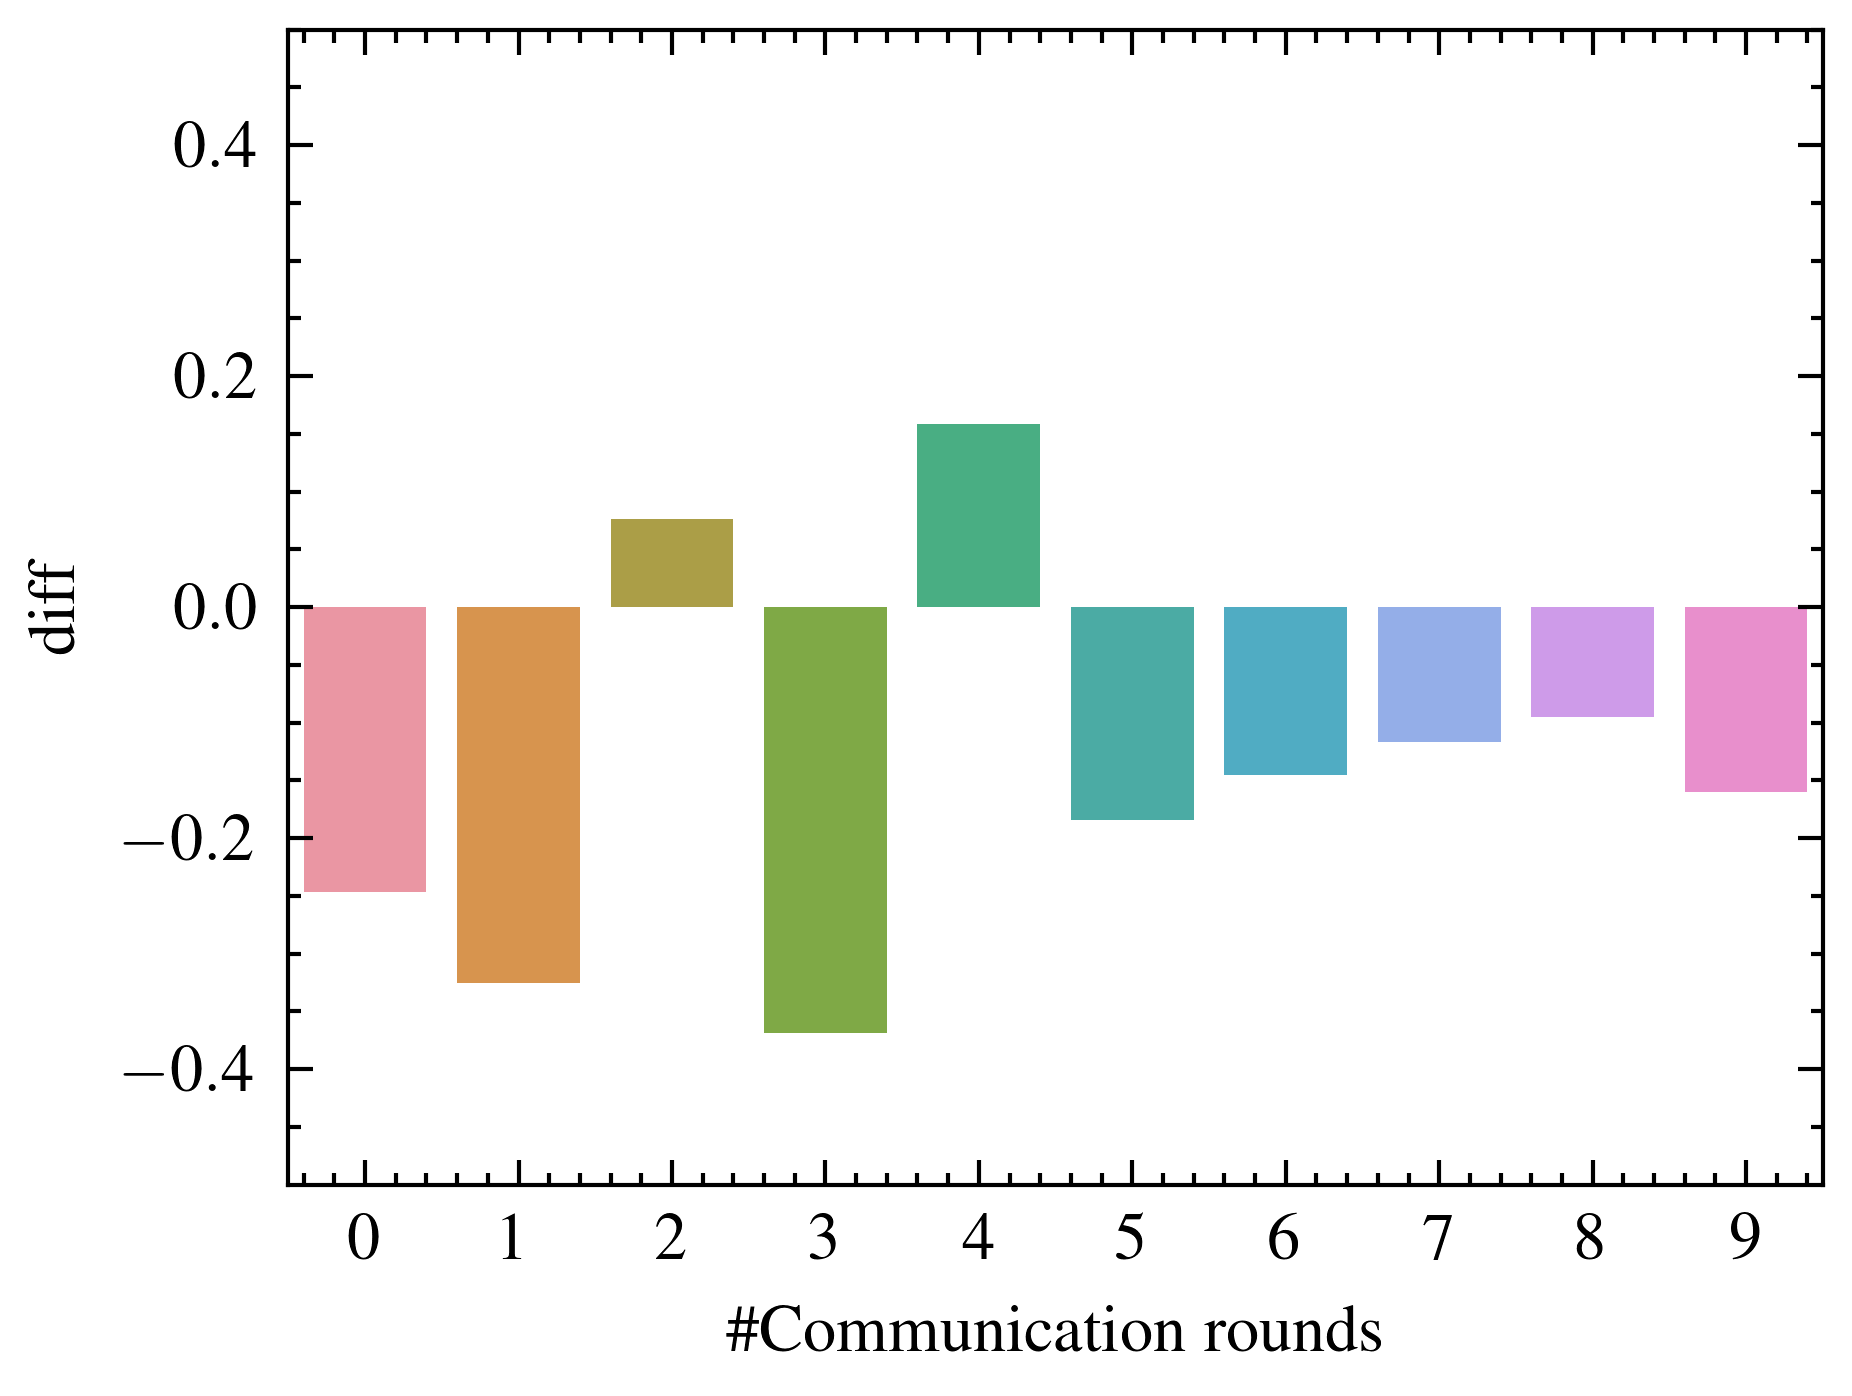

In [167]:
print(data_df)
print(data_df["diff"].abs().mean())

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
sns.barplot(x = data_df.index, y = "diff",data = data_df)
plt.ylim(-0.5,0.5)
plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

### MOON

   precision    recall  f1-score  support  confidence      diff
0   0.710000  0.569138  0.631813    998.0    0.534844 -0.175156
1   0.847126  0.737738  0.788657    999.0    0.698898 -0.148229
2   0.438572  0.639640  0.520358    999.0    0.525694  0.087122
3   0.846154  0.011033  0.021782    997.0    0.146823 -0.699331
4   0.533269  0.553000  0.542955   1000.0    0.400857 -0.132412
5   0.414343  0.834504  0.553744    997.0    0.684476  0.270134
6   0.575312  0.783000  0.663278   1000.0    0.654491  0.079178
7   0.929504  0.357071  0.515942    997.0    0.418867 -0.510637
8   0.778261  0.718154  0.747001    997.0    0.574286 -0.203975
9   0.704846  0.800000  0.749415   1000.0    0.658890 -0.045956
0.2352128341349812


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


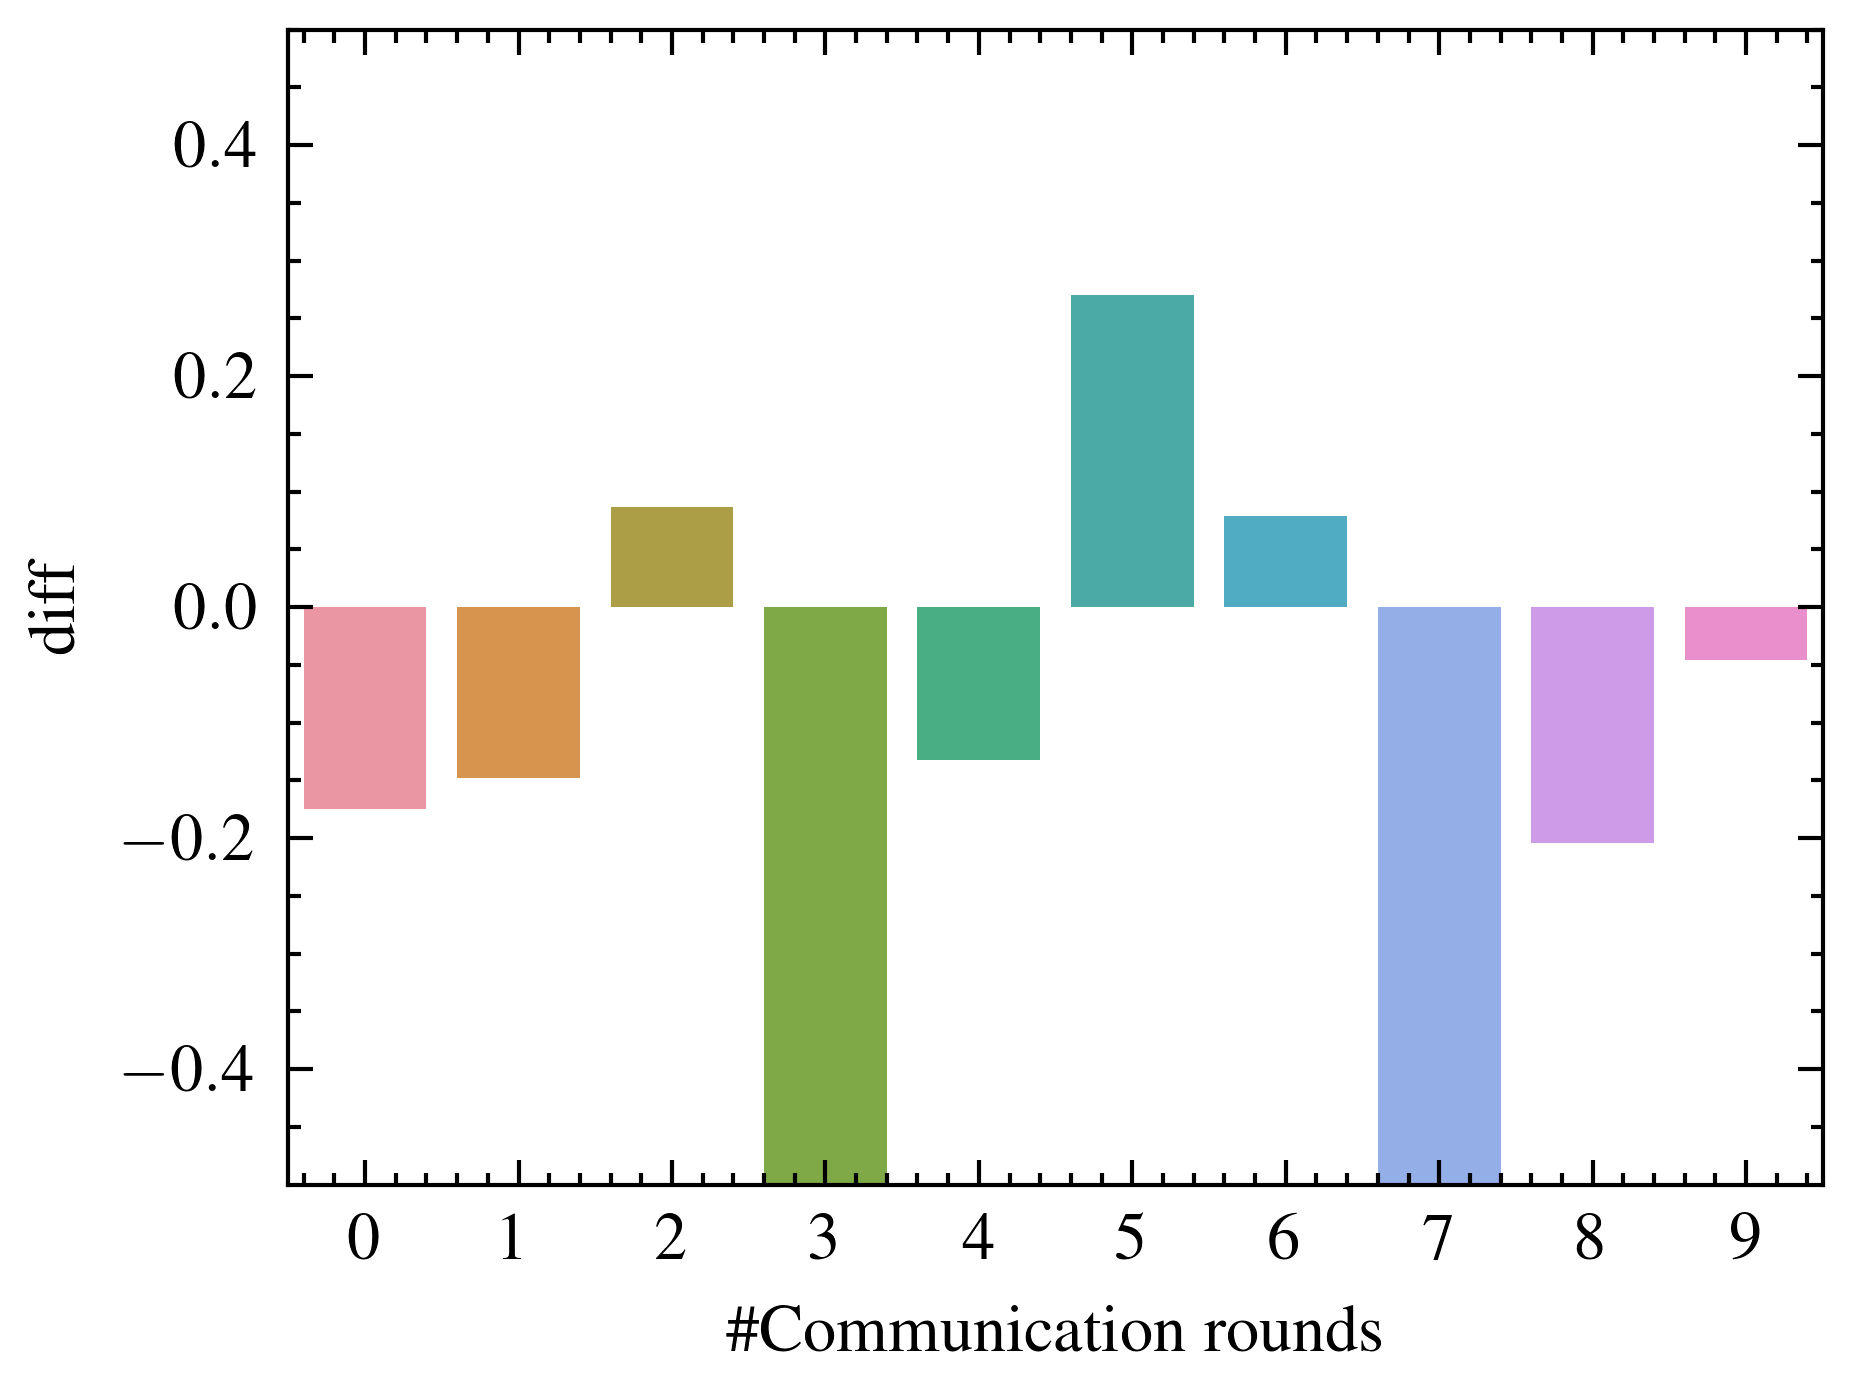

In [169]:
print(data_df)
print(data_df["diff"].abs().mean())

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
sns.barplot(x = data_df.index, y = "diff",data = data_df)
plt.ylim(-0.5,0.5)
plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

### FedRs

   precision    recall  f1-score  support  confidence      diff
0   0.695652  0.609218  0.649573    998.0    0.858760  0.163108
1   0.488164  0.928929  0.640000    999.0    0.974200  0.486036
2   0.567026  0.368368  0.446602    999.0    0.800342  0.233316
3   0.423901  0.377131  0.399151    997.0    0.651671  0.227770
4   0.483757  0.685000  0.567053   1000.0    0.899602  0.415845
5   0.465551  0.725176  0.567059    997.0    0.876786  0.411235
6   0.665039  0.681000  0.672925   1000.0    0.922921  0.257882
7   0.811550  0.535607  0.645317    997.0    0.863250  0.051700
8   0.823856  0.595787  0.691502    997.0    0.828865  0.005009
9   0.903654  0.272000  0.418140   1000.0    0.716106 -0.187548
0.24394504267079925


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


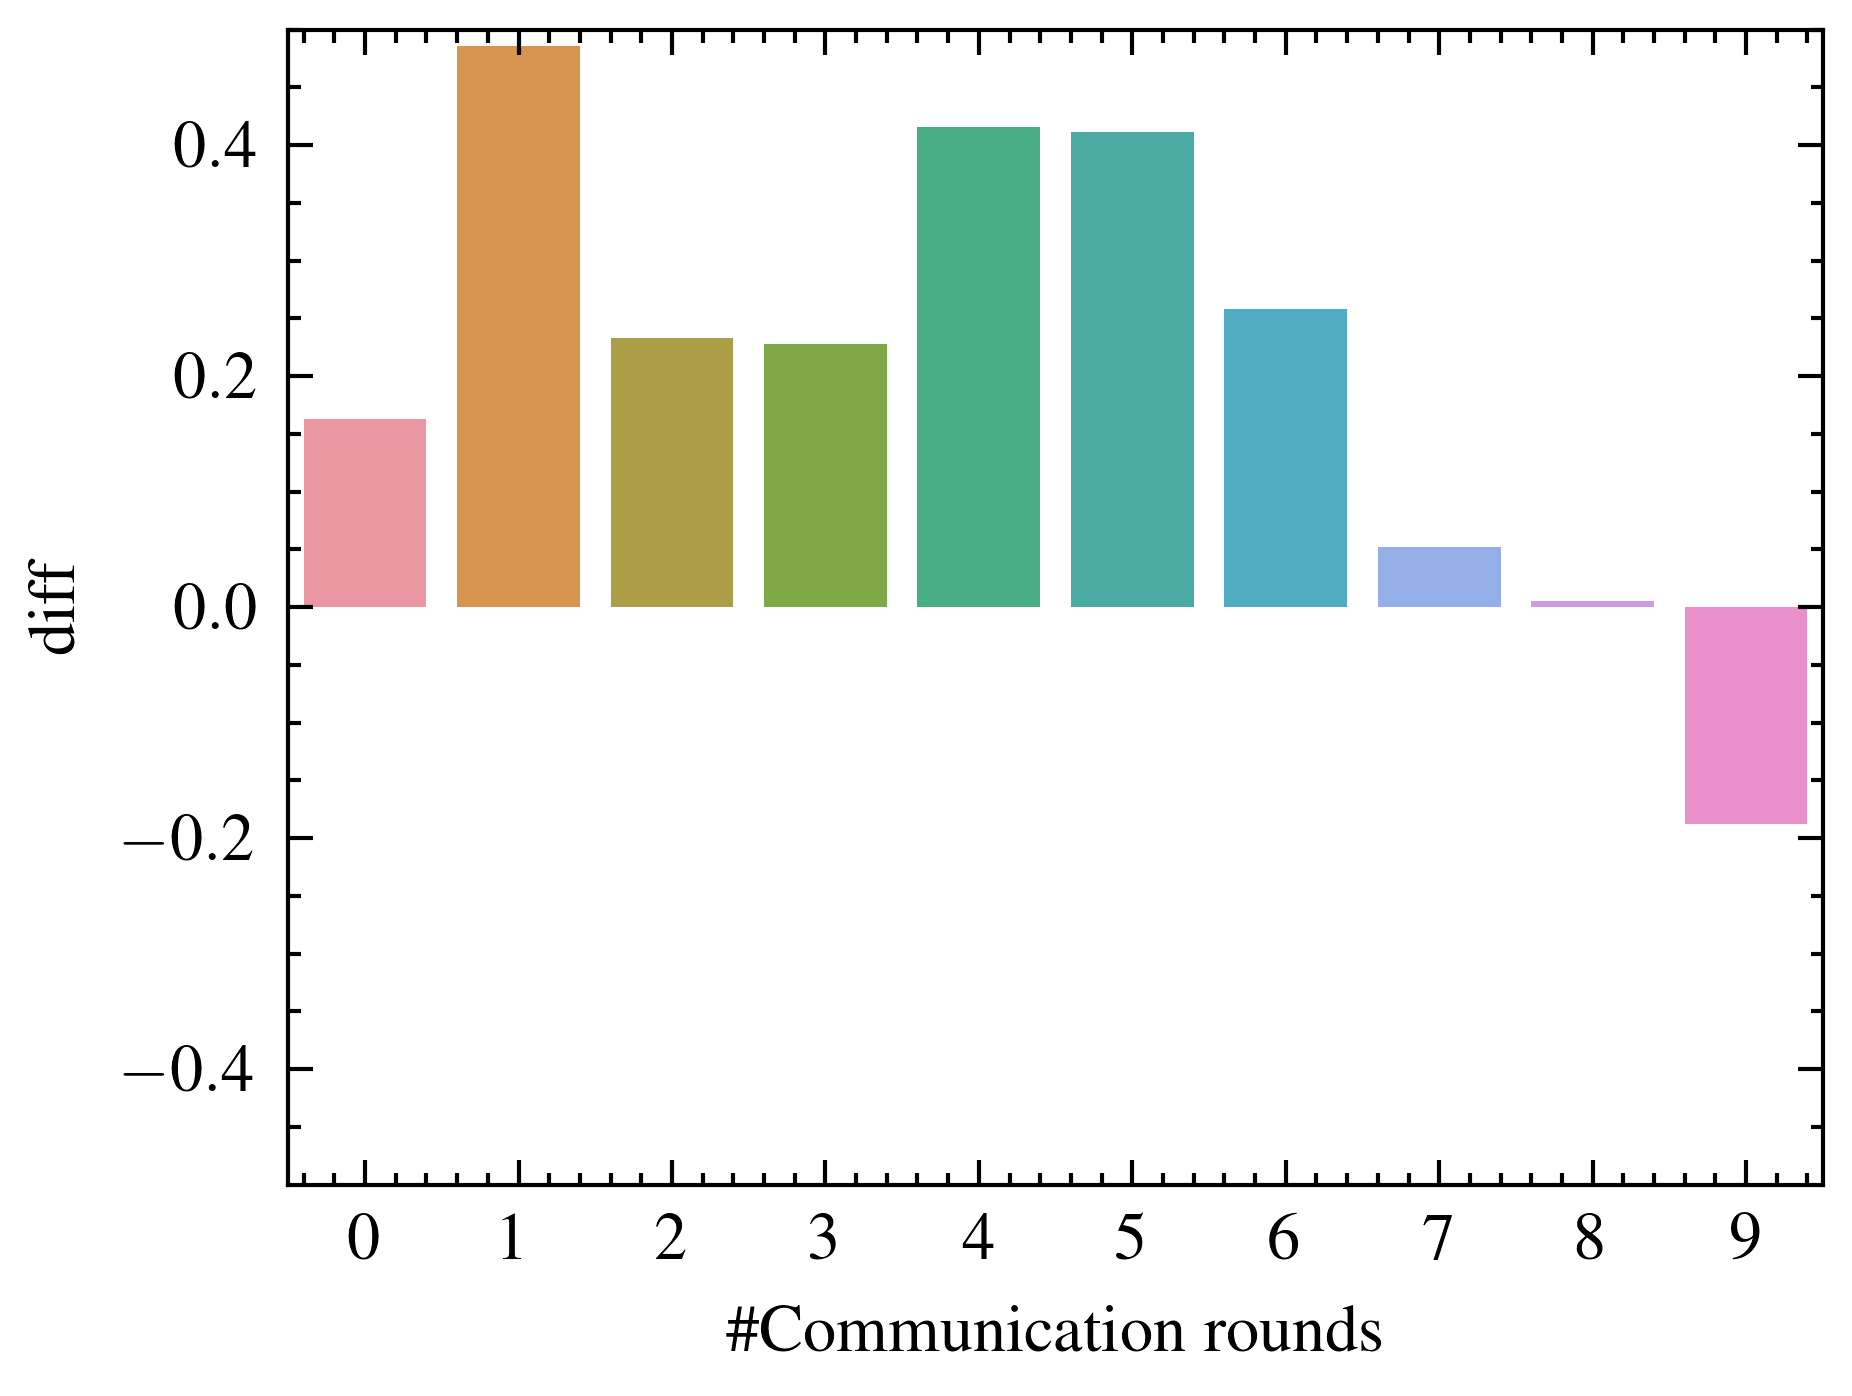

In [171]:
print(data_df)
print(data_df["diff"].abs().mean())

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
sns.barplot(x = data_df.index, y = "diff",data = data_df)
plt.ylim(-0.5,0.5)
plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

### FedRod

   precision    recall  f1-score  support  confidence      diff
0   0.712240  0.548096  0.619479    998.0    0.847083  0.134843
1   0.455202  0.945946  0.614634    999.0    0.978741  0.523539
2   0.508584  0.474474  0.490937    999.0    0.818694  0.310111
3   0.385399  0.455366  0.417471    997.0    0.689759  0.304360
4   0.640940  0.382000  0.478697   1000.0    0.764609  0.123670
5   0.479802  0.679037  0.562292    997.0    0.843428  0.363627
6   0.700954  0.661000  0.680391   1000.0    0.895825  0.194871
7   0.671442  0.705115  0.687867    997.0    0.905150  0.233708
8   0.793842  0.594784  0.680046    997.0    0.859953  0.066111
9   0.874126  0.250000  0.388802   1000.0    0.672581 -0.201545
0.245638299784029


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


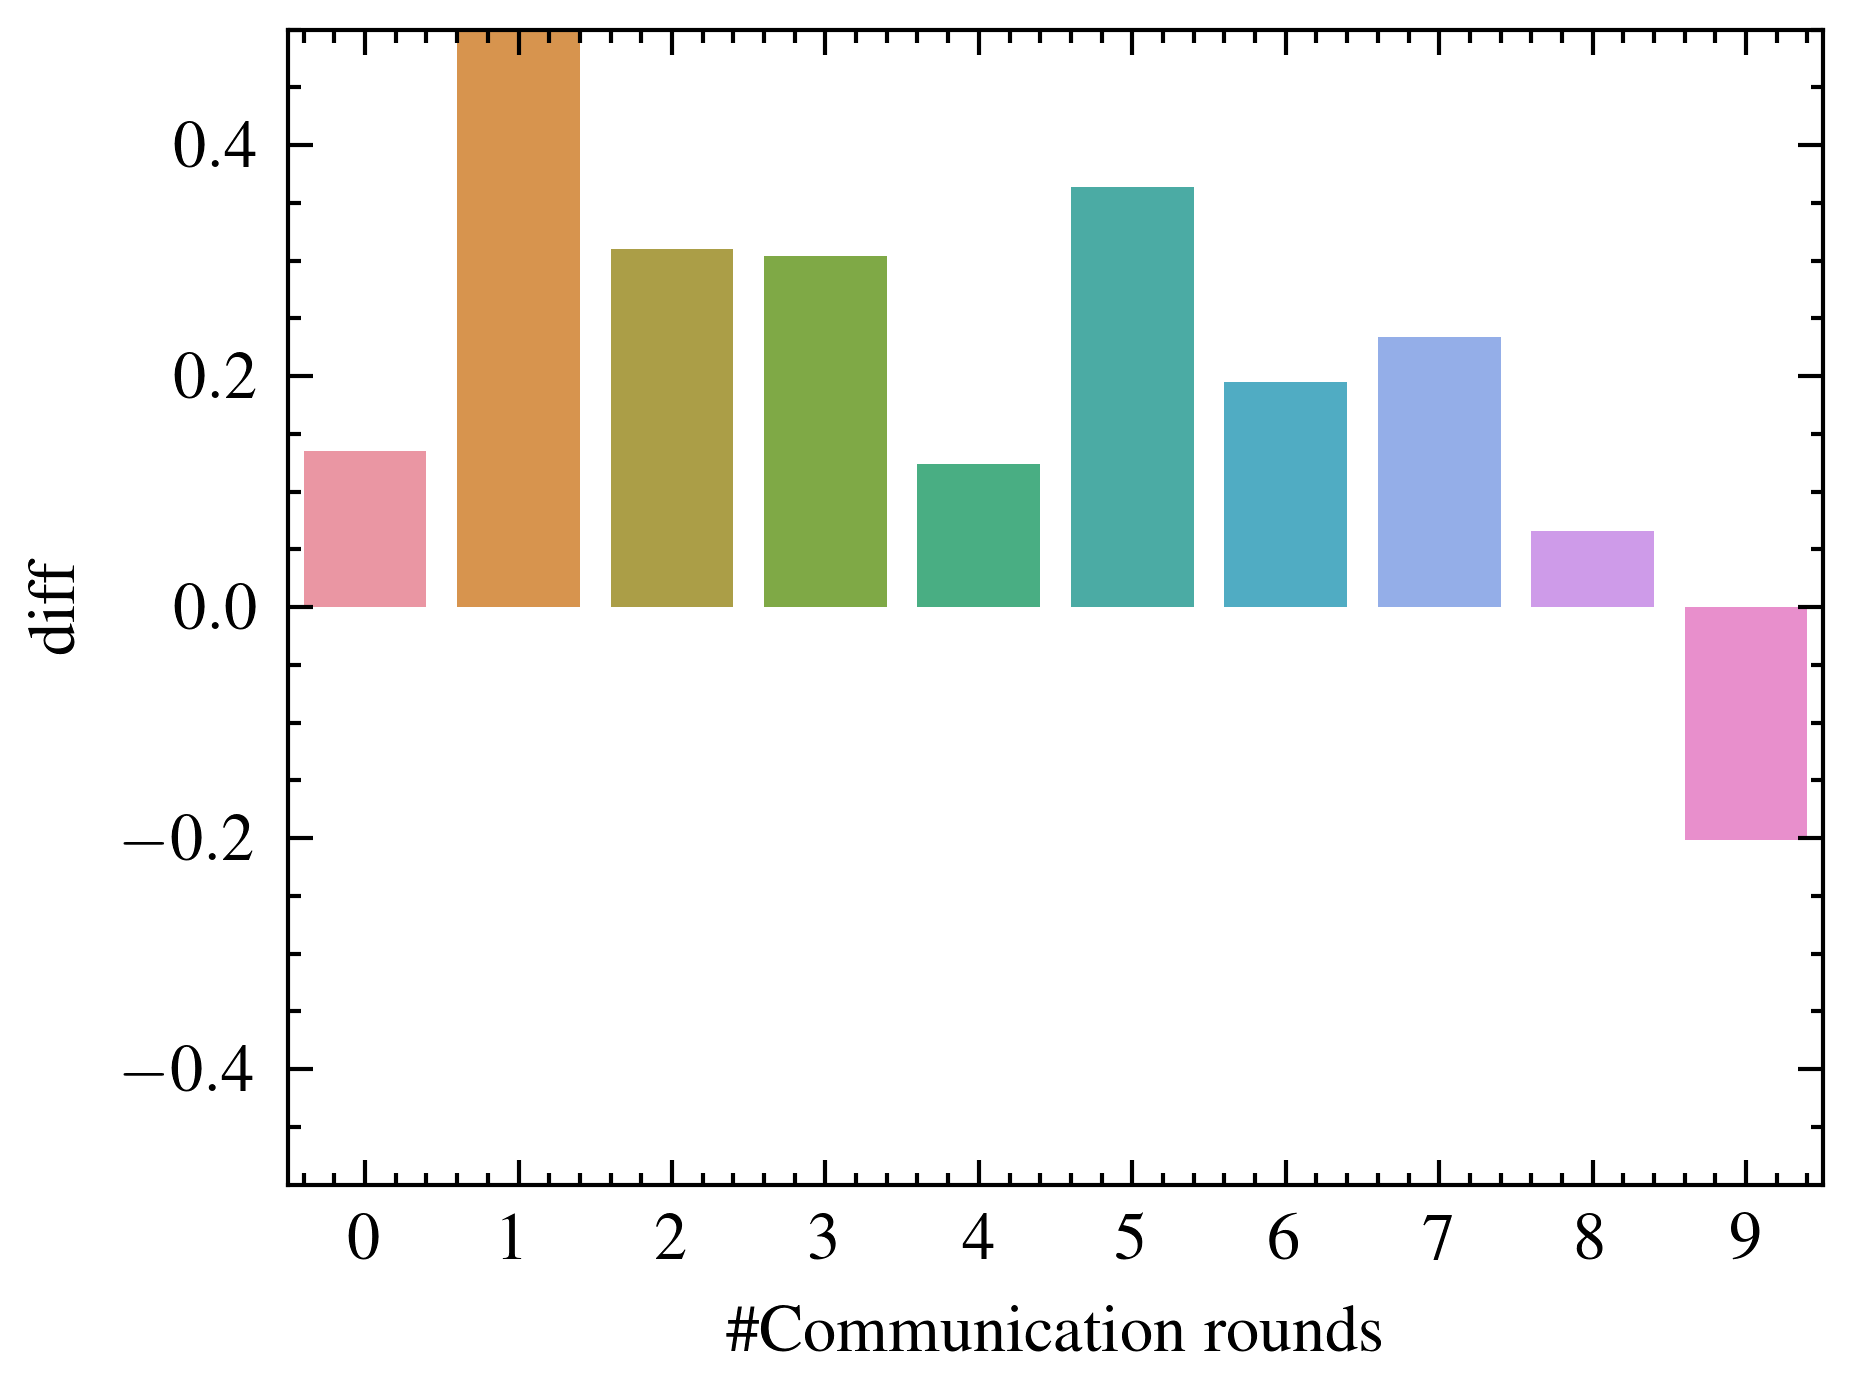

In [173]:
print(data_df)
print(data_df["diff"].abs().mean())

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
sns.barplot(x = data_df.index, y = "diff",data = data_df)
plt.ylim(-0.5,0.5)
plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

### FedProx

   precision    recall  f1-score  support  confidence      diff
0   0.609278  0.592184  0.600610    998.0    0.506604 -0.102675
1   0.703191  0.661662  0.681795    999.0    0.504125 -0.199067
2   0.657993  0.177177  0.279180    999.0    0.295754 -0.362239
3   0.396070  0.525577  0.451724    997.0    0.316280 -0.079789
4   0.425843  0.669000  0.520420   1000.0    0.490622  0.064778
5   0.534504  0.427282  0.474916    997.0    0.395710 -0.138794
6   0.591673  0.739000  0.657181   1000.0    0.625297  0.033623
7   0.711842  0.542628  0.615822    997.0    0.502943 -0.208899
8   0.597896  0.741224  0.661890    997.0    0.565876 -0.032020
9   0.689298  0.599000  0.640984   1000.0    0.454619 -0.234679
0.14565634764607763


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


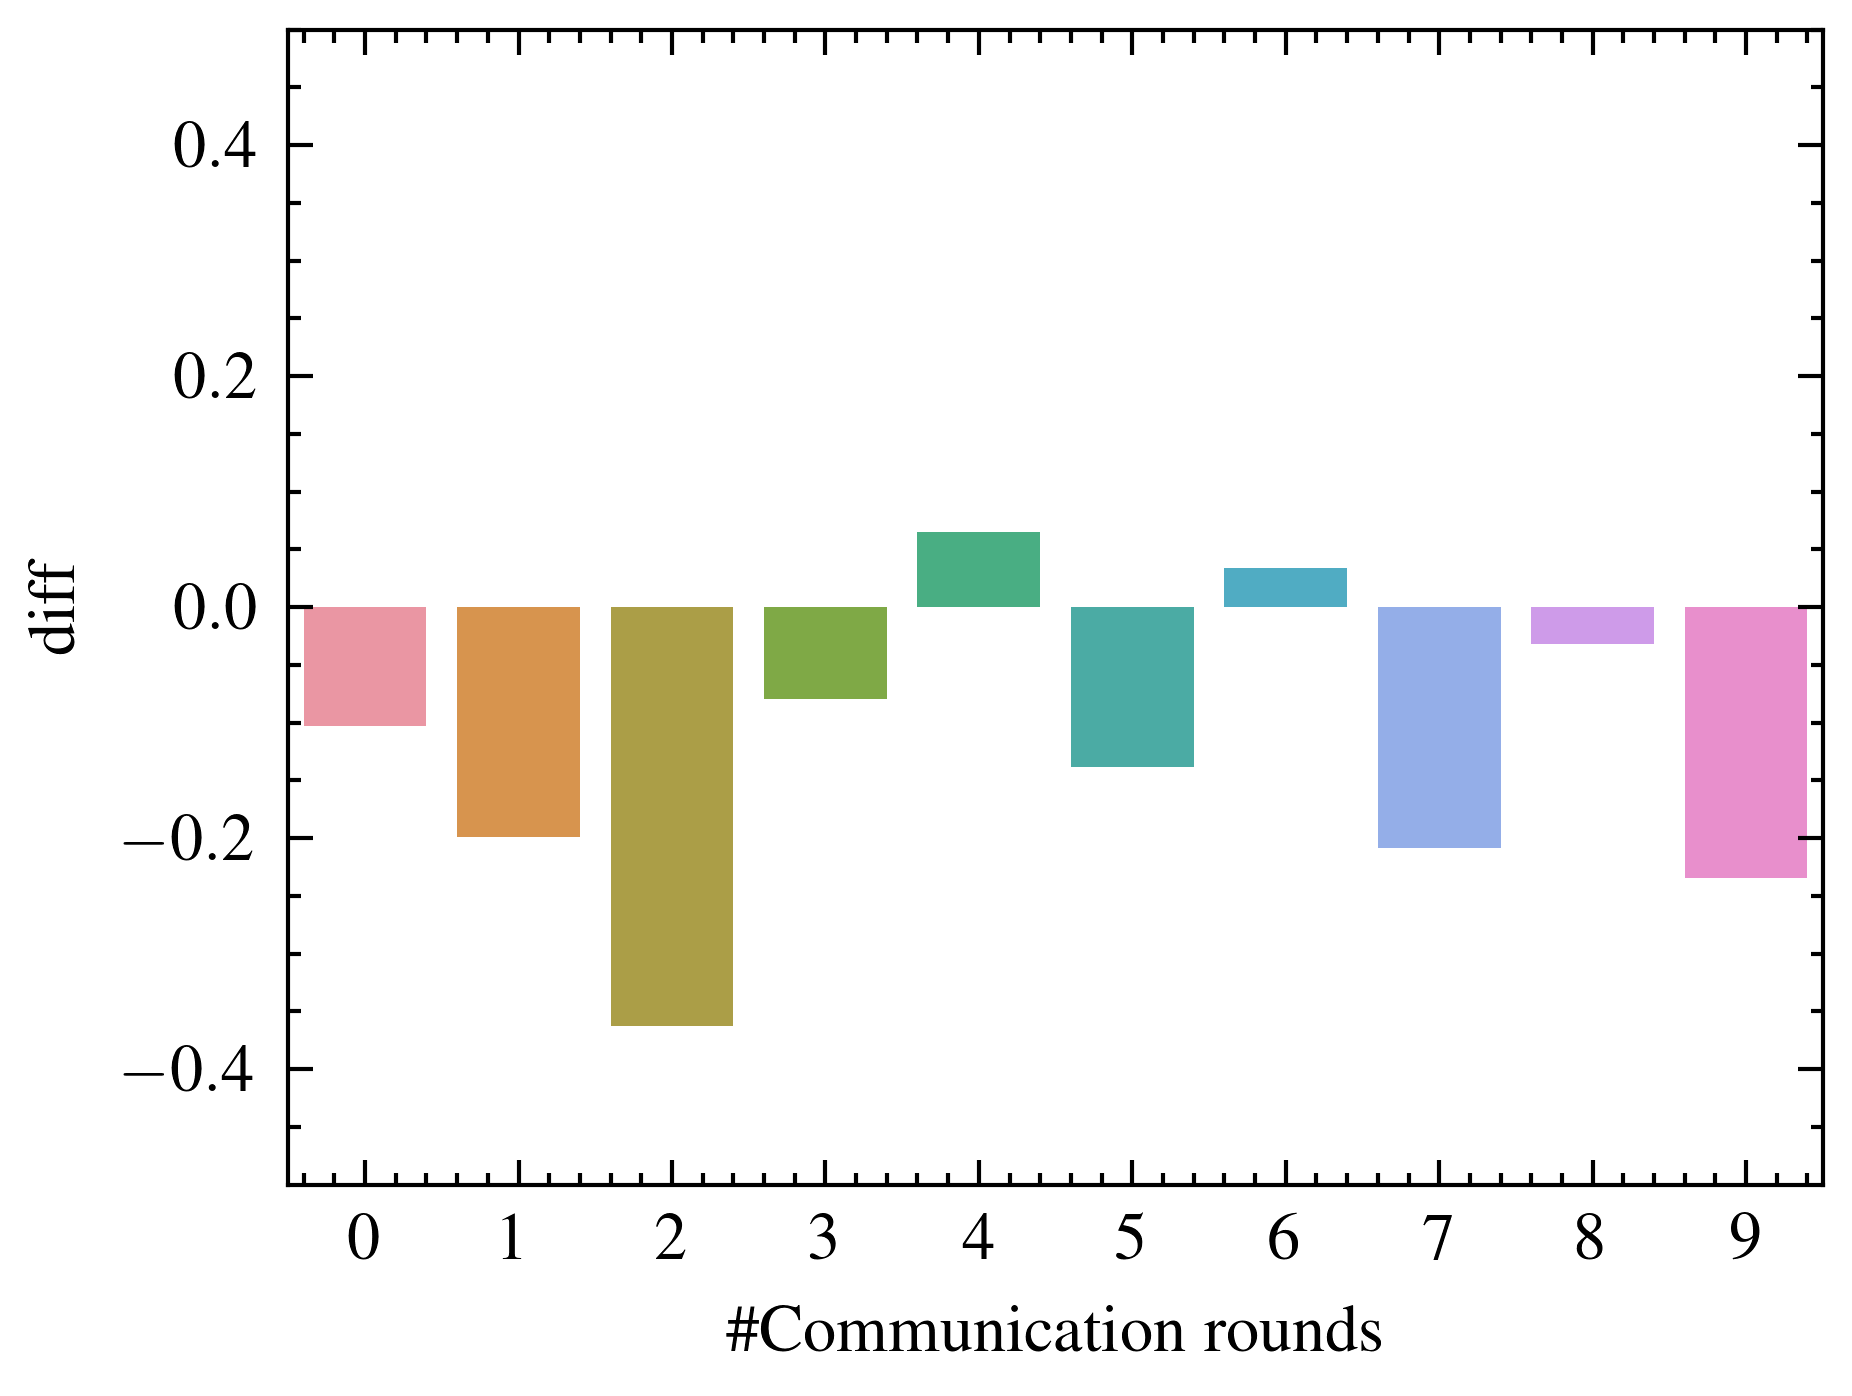

In [175]:
print(data_df)
print(data_df["diff"].abs().mean())

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
sns.barplot(x = data_df.index, y = "diff",data = data_df)
plt.ylim(-0.5,0.5)
plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

In [205]:
model  = resnet8(10)

paras_old = model.state_dict()
# print(len(.keys()))
paras = torch.load("/mnt/data/th/FedAlign/logs/20221010_003739__fedavg_e10_c100/server.pt")

for key,value in zip(list(paras_old.keys()),list(paras.values())):
    paras_old[key] = value

model.load_state_dict(paras_old)
device = torch.device("cuda")
model.to(device)

ResNet(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (stage_1): Sequential(
    (0): BasicBlock(
      (conv_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage_2): Sequential(
    (0): BasicBlock(
      (conv_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv2d(32, 32, kernel_size=(3, 3), s

In [186]:

dict_client_idexes, class_num, client_infos = get_client_idxes_dict(
        "/mnt/data/th/FedTH/data/dataset/cifar10/", "hetero", 0.2, 100)



INFO:root:*********partition data***************
INFO:root:N = 50000
INFO:root:traindata_cls_counts = {0: {1: 45, 3: 110, 5: 1, 6: 113, 7: 7, 8: 3, 9: 5}, 1: {0: 80, 1: 308, 2: 3, 3: 6, 4: 92, 5: 506}, 2: {0: 141, 1: 98, 2: 138, 3: 297}, 3: {0: 31, 1: 1, 2: 5, 4: 81, 7: 20, 8: 84}, 4: {1: 185, 2: 1, 4: 1, 5: 77, 6: 121, 7: 76, 8: 69}, 5: {0: 5, 1: 63, 2: 40, 5: 1, 6: 35, 7: 4, 8: 160, 9: 2}, 6: {0: 68, 1: 5, 2: 83, 3: 12, 4: 251, 5: 2, 7: 7, 9: 49}, 7: {0: 1, 1: 7, 2: 4, 4: 281, 5: 18, 7: 47, 8: 131}, 8: {0: 46, 2: 43, 3: 304, 4: 85, 5: 2, 6: 1, 8: 5, 9: 3}, 9: {0: 61, 1: 6, 2: 1, 3: 38, 4: 2, 5: 108, 6: 10, 7: 5, 9: 127}, 10: {0: 6, 1: 3, 2: 101, 4: 10, 6: 5, 7: 3, 8: 18, 9: 1}, 11: {2: 2, 3: 65, 4: 13, 5: 17, 6: 73, 7: 65, 8: 1, 9: 223}, 12: {0: 3, 1: 246, 2: 180, 3: 498}, 13: {0: 27, 2: 8, 4: 1, 5: 589}, 14: {0: 684}, 15: {0: 19, 1: 2, 2: 20, 3: 213, 4: 20, 6: 12, 8: 338}, 16: {1: 11, 2: 3, 3: 315, 4: 4, 5: 289}, 17: {1: 3, 2: 10, 3: 89, 7: 3, 8: 53, 9: 32}, 18: {0: 35, 1: 19, 2: 71

In [201]:
train_dl,val_dl =  get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=1, train=True)

INFO:root:train batch: 13,val batch: 6


In [200]:
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
criterion = torch.nn.CrossEntropyLoss().to(device)
epoch_loss = []
for epoch in range(10):
    batch_loss = []
    for batch_idx, (images, labels) in enumerate(train_dl):
        # logging.info(images.shape)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_probs = model(images)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    print(numpy.array(batch_loss).mean())

model.eval()
preds = None
labels = None
logits_list = [[] for x in range(10)] 
# print(logits_list)

with torch.no_grad():
    for x,y in test_dl:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)

        probs = torch.softmax(logits,dim=1)

        maxlogits,preds_inner = torch.max(probs,dim=1)

        if preds is None:
            preds = preds_inner.cpu()
            labels = y.cpu()
        else:
            preds = numpy.concatenate((preds,preds_inner.cpu()))
            labels = numpy.concatenate((labels,y.cpu()))
        for logit,pred,label in zip(maxlogits.cpu()**2,preds_inner.cpu(),y.cpu()):
            if pred == label:
                logits_list[pred].append(logit.data)
print(preds)
   
res = classification_report(labels,preds,output_dict = True)
for index,class_list in enumerate(logits_list):
    confidence_class = numpy.array(class_list).mean()
    res[str(index)].update({"confidence":confidence_class})
    # confidence.append(confidence_class)

import pandas

data_df = pandas.DataFrame(res).T

data_df = data_df.drop("accuracy").drop("macro avg").drop("weighted avg")

data_df["diff"] = data_df["confidence"]-data_df["precision"]
print(data_df)
#0: {1: 45, 3: 110, 5: 1, 6: 113, 7: 7, 8: 3, 9: 5}


[3 1 8 ... 3 3 1]
   precision    recall  f1-score  support  confidence      diff
0   0.774194  0.024048  0.046647    998.0    0.417543 -0.356651
1   0.411765  0.882883  0.561605    999.0    0.841269  0.429505
2   0.000000  0.000000  0.000000    999.0         NaN       NaN
3   0.183790  0.900702  0.305286    997.0    0.864029  0.680239
4   0.000000  0.000000  0.000000   1000.0         NaN       NaN
5   0.000000  0.000000  0.000000    997.0         NaN       NaN
6   0.510117  0.479000  0.494069   1000.0    0.687739  0.177622
7   0.639286  0.179539  0.280345    997.0    0.623023 -0.016263
8   0.729600  0.457372  0.562269    997.0    0.537938 -0.191662
9   0.490287  0.530000  0.509370   1000.0    0.585447  0.095160


/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anacon

In [199]:
print(labels)

# print(label.cpu().reshape((1,-1)))

for i in labels.reshape((-1,1)):
    print(i)

[3 8 8 ... 4 2 0]
[3]
[8]
[8]
[0]
[6]
[6]
[1]
[6]
[3]
[1]
[0]
[9]
[5]
[7]
[9]
[8]
[5]
[7]
[8]
[6]
[7]
[0]
[4]
[9]
[5]
[2]
[4]
[0]
[9]
[6]
[6]
[5]
[4]
[5]
[9]
[2]
[4]
[1]
[9]
[5]
[4]
[6]
[5]
[6]
[0]
[9]
[3]
[9]
[7]
[6]
[9]
[8]
[0]
[3]
[8]
[8]
[7]
[7]
[4]
[6]
[7]
[3]
[6]
[3]
[6]
[2]
[1]
[2]
[3]
[7]
[2]
[6]
[8]
[8]
[0]
[2]
[9]
[3]
[3]
[8]
[8]
[1]
[1]
[7]
[2]
[5]
[2]
[7]
[8]
[9]
[0]
[3]
[8]
[6]
[4]
[6]
[6]
[0]
[0]
[7]
[4]
[5]
[6]
[3]
[1]
[1]
[3]
[6]
[8]
[7]
[4]
[0]
[6]
[2]
[1]
[3]
[0]
[4]
[2]
[7]
[8]
[3]
[1]
[2]
[8]
[0]
[8]
[3]
[5]
[2]
[4]
[1]
[8]
[9]
[1]
[2]
[9]
[7]
[2]
[9]
[6]
[5]
[6]
[3]
[8]
[7]
[6]
[2]
[5]
[2]
[8]
[9]
[6]
[0]
[0]
[5]
[2]
[9]
[5]
[4]
[2]
[1]
[6]
[6]
[8]
[4]
[8]
[4]
[5]
[0]
[9]
[9]
[9]
[8]
[9]
[9]
[3]
[7]
[5]
[0]
[0]
[5]
[2]
[2]
[3]
[8]
[6]
[3]
[4]
[0]
[5]
[8]
[0]
[1]
[7]
[2]
[8]
[8]
[7]
[8]
[5]
[1]
[8]
[7]
[1]
[3]
[0]
[5]
[7]
[9]
[7]
[4]
[5]
[9]
[8]
[0]
[7]
[9]
[8]
[2]
[7]
[6]
[9]
[4]
[3]
[9]
[6]
[4]
[7]
[6]
[5]
[1]
[5]
[8]
[8]
[0]
[4]
[0]
[5]
[5]
[1]
[1]
[8]
[9]
[0]
[3

In [206]:
train_dl,val_dl =  get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=2, train=True)

model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
criterion = torch.nn.CrossEntropyLoss().to(device)
epoch_loss = []
for epoch in range(10):
    batch_loss = []
    for batch_idx, (images, labels) in enumerate(train_dl):
        # logging.info(images.shape)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_probs = model(images)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    print(numpy.array(batch_loss).mean())

model.eval()
preds = None
labels = None
logits_list = [[] for x in range(10)] 
# print(logits_list)

with torch.no_grad():
    for x,y in test_dl:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)

        probs = torch.softmax(logits,dim=1)

        maxlogits,preds_inner = torch.max(probs,dim=1)

        if preds is None:
            preds = preds_inner.cpu()
            labels = y.cpu()
        else:
            preds = numpy.concatenate((preds,preds_inner.cpu()))
            labels = numpy.concatenate((labels,y.cpu()))
        for logit,pred,label in zip(maxlogits.cpu()**2,preds_inner.cpu(),y.cpu()):
            if pred == label:
                logits_list[pred].append(logit.data)
print(preds)
   
res = classification_report(labels,preds,output_dict = True)
for index,class_list in enumerate(logits_list):
    confidence_class = numpy.array(class_list).mean()
    res[str(index)].update({"confidence":confidence_class})
    # confidence.append(confidence_class)

import pandas

data_df = pandas.DataFrame(res).T

data_df = data_df.drop("accuracy").drop("macro avg").drop("weighted avg")

data_df["diff"] = data_df["confidence"]-data_df["precision"]
print(data_df)
#2: {0: 141, 1: 98, 2: 138, 3: 297}


INFO:root:train batch: 9,val batch: 4


1.2641921838124592
0.6456004910998874
0.5755655666192373
0.5224049852954017
0.4656664927800496
0.4693192044893901
0.44453508655230206
0.44738002287016976
0.40341142151090836
0.4333434005578359
[3 1 1 ... 2 3 0]
   precision    recall  f1-score  support  confidence      diff
0   0.389535  0.604208  0.473684    998.0    0.754258  0.364723
1   0.537762  0.769770  0.633182    999.0    0.841959  0.304197
2   0.306660  0.594595  0.404632    999.0    0.760140  0.453480
3   0.181101  0.920762  0.302671    997.0    0.912089  0.730988
4   0.000000  0.000000  0.000000   1000.0         NaN       NaN
5   0.000000  0.000000  0.000000    997.0         NaN       NaN
6   0.000000  0.000000  0.000000   1000.0         NaN       NaN
7   0.000000  0.000000  0.000000    997.0         NaN       NaN
8   0.000000  0.000000  0.000000    997.0         NaN       NaN
9   0.000000  0.000000  0.000000   1000.0         NaN       NaN


/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anacon

In [211]:


def run_single_client(client_idx):

    train_dl,val_dl =  get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=client_idx, train=True)

    print(client_infos[client_idx])

    model  = resnet8(10)

    paras_old = model.state_dict()
    # print(len(.keys()))
    paras = torch.load("/mnt/data/th/FedAlign/logs/20221010_003739__fedavg_e10_c100/server.pt")

    for key,value in zip(list(paras_old.keys()),list(paras.values())):
        paras_old[key] = value

    model.load_state_dict(paras_old)
    device = torch.device("cuda")
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    epoch_loss = []
    for epoch in range(10):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_probs = model(images)
            loss = criterion(log_probs, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        # print(numpy.array(batch_loss).mean())

    model.eval()
    preds = None
    labels = None
    logits_list = [[] for x in range(10)] 
    # print(logits_list)

    with torch.no_grad():
        for x,y in test_dl:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)

            probs = torch.softmax(logits,dim=1)

            maxlogits,preds_inner = torch.max(probs,dim=1)

            if preds is None:
                preds = preds_inner.cpu()
                labels = y.cpu()
            else:
                preds = numpy.concatenate((preds,preds_inner.cpu()))
                labels = numpy.concatenate((labels,y.cpu()))
            for logit,pred,label in zip(maxlogits.cpu()**2,preds_inner.cpu(),y.cpu()):
                if pred == label:
                    logits_list[pred].append(logit.data)
    # print(preds)
    
    res = classification_report(labels,preds,output_dict = True)
    for index,class_list in enumerate(logits_list):
        confidence_class = numpy.array(class_list).mean()
        res[str(index)].update({"confidence":confidence_class})
        # confidence.append(confidence_class)

    import pandas

    data_df = pandas.DataFrame(res).T

    data_df = data_df.drop("accuracy").drop("macro avg").drop("weighted avg")

    data_df["diff"] = data_df["confidence"]-data_df["precision"]
    print(data_df)
    #2: {0: 141, 1: 98, 2: 138, 3: 297}


In [212]:
run_single_client(3)

INFO:root:train batch: 3,val batch: 1


{0: 31, 1: 1, 2: 5, 4: 81, 7: 20, 8: 84}
   precision    recall  f1-score  support  confidence      diff
0   0.444895  0.550100  0.491935    998.0    0.650226  0.205331
1   0.795455  0.035035  0.067114    999.0    0.296915 -0.498539
2   0.425856  0.112112  0.177496    999.0    0.399146 -0.026709
3   0.000000  0.000000  0.000000    997.0         NaN       NaN
4   0.208174  0.871000  0.336034   1000.0    0.855789  0.647615
5   0.000000  0.000000  0.000000    997.0         NaN       NaN
6   0.769231  0.010000  0.019743   1000.0    0.368374 -0.400856
7   0.497418  0.579739  0.535433    997.0    0.648945  0.151527
8   0.285761  0.881645  0.431623    997.0    0.874188  0.588427
9   0.500000  0.003000  0.005964   1000.0    0.304409 -0.195591


/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anacon

In [213]:
run_single_client(4)

INFO:root:train batch: 7,val batch: 3


{1: 185, 2: 1, 4: 1, 5: 77, 6: 121, 7: 76, 8: 69}
   precision    recall  f1-score  support  confidence      diff
0   1.000000  0.003006  0.005994    998.0    0.234443 -0.765557
1   0.354721  0.973974  0.520043    999.0    0.951504  0.596783
2   0.761905  0.032032  0.061479    999.0    0.380793 -0.381111
3   0.000000  0.000000  0.000000    997.0         NaN       NaN
4   0.000000  0.000000  0.000000   1000.0         NaN       NaN
5   0.438527  0.669007  0.529786    997.0    0.727521  0.288993
6   0.437120  0.862000  0.580081   1000.0    0.902166  0.465047
7   0.448391  0.810431  0.577349    997.0    0.853743  0.405352
8   0.428421  0.816449  0.561961    997.0    0.875051  0.446630
9   1.000000  0.001000  0.001998   1000.0    0.271094 -0.728906


/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ict/anacon

In [214]:
run_single_client(5)

INFO:root:train batch: 4,val batch: 1


{0: 5, 1: 63, 2: 40, 5: 1, 6: 35, 7: 4, 8: 160, 9: 2}
   precision    recall  f1-score  support  confidence      diff
0   0.721739  0.166333  0.270358    998.0    0.456234 -0.265505
1   0.519789  0.788789  0.626640    999.0    0.846100  0.326311
2   0.250189  0.662663  0.363237    999.0    0.749089  0.498900
3   0.714286  0.005015  0.009960    997.0    0.137827 -0.576459
4   0.777778  0.007000  0.013875   1000.0    0.186529 -0.591249
5   0.846154  0.011033  0.021782    997.0    0.175439 -0.670715
6   0.505755  0.747000  0.603149   1000.0    0.819321  0.313566
7   0.784074  0.513541  0.620606    997.0    0.711623 -0.072450
8   0.283363  0.949850  0.436506    997.0    0.931834  0.648471
9   0.879121  0.080000  0.146654   1000.0    0.406456 -0.472665


In [231]:
from FedML.fedml_api.data_preprocessing.cifar100.data_loader import get_client_idxes_dict, get_client_dataloader
import os
dict_client_idexes, class_num, client_infos = get_client_idxes_dict(
        "/mnt/data/th/FedTH/data/dataset/cifar100", "hetero", 0.2, 100)



def run_single_client_cifar100(train=False,test = False,client_idx = 0,log = None):

    train_dl,val_dl =  get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar100", 64, dict_client_idexes, client_idx=client_idx, train=True)

    test_dl = get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar100", 64, dict_client_idexes, client_idx=None, train=False)

    print(client_infos[client_idx])

    model  = resnet20(100)

    paras_old = model.state_dict()
    # print(len(.keys()))
    paras = torch.load(os.path.join("/mnt/data/th/FedAlign",log,"server.pt"))

    for key,value in zip(list(paras_old.keys()),list(paras.values())):
        paras_old[key] = value

    model.load_state_dict(paras_old)
    device = torch.device("cuda")
    model.to(device)

    if train:
        model.train()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
        criterion = torch.nn.CrossEntropyLoss().to(device)
        epoch_loss = []
        for epoch in range(10):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(train_dl):
                # logging.info(images.shape)
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                log_probs = model(images)
                loss = criterion(log_probs, labels)
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())
            # print(numpy.array(batch_loss).mean())
    acc_dl = test_dl if test else val_dl
    model.eval()
    preds = None
    labels = None
    logits_list = [[] for x in range(100)] 
    # print(logits_list)

    with torch.no_grad():
        for x,y in acc_dl:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)

            probs = torch.softmax(logits,dim=1)

            maxlogits,preds_inner = torch.max(probs,dim=1)

            if preds is None:
                preds = preds_inner.cpu()
                labels = y.cpu()
            else:
                preds = numpy.concatenate((preds,preds_inner.cpu()))
                labels = numpy.concatenate((labels,y.cpu()))
            for logit,pred,label in zip(maxlogits.cpu()**2,preds_inner.cpu(),y.cpu()):
                if pred == label:
                    logits_list[pred].append(logit.data)
    # print(preds)
    
    res = classification_report(labels,preds,output_dict = True)
    for index,class_list in enumerate(logits_list):
        confidence_class = numpy.array(class_list).mean()
        res[str(index)].update({"confidence":confidence_class})
        # confidence.append(confidence_class)

    import pandas

    data_df = pandas.DataFrame(res).T

    data_df = data_df.drop("accuracy").drop("macro avg").drop("weighted avg")

    data_df["diff"] = data_df["confidence"]-data_df["precision"]
    print(data_df)

    return data_df
    #2: {0: 141, 1: 98, 2: 138, 3: 297}


INFO:root:*********partition data***************
INFO:root:N = 50000
INFO:root:traindata_cls_counts = {0: {1: 2, 3: 28, 4: 6, 5: 15, 6: 2, 7: 3, 8: 6, 9: 21, 11: 1, 13: 25, 14: 36, 20: 22, 23: 3, 24: 2, 25: 16, 26: 3, 28: 4, 29: 1, 37: 29, 45: 10, 46: 13, 48: 1, 53: 8, 58: 81, 60: 10, 61: 2, 64: 3, 65: 1, 68: 10, 70: 1, 72: 2, 73: 2, 74: 10, 75: 14, 77: 2, 78: 18, 79: 23, 81: 1, 82: 11, 83: 13, 85: 15, 86: 1, 87: 1, 88: 27}, 1: {0: 10, 3: 7, 8: 7, 9: 21, 10: 1, 14: 12, 15: 1, 16: 2, 20: 6, 22: 14, 24: 23, 25: 16, 27: 7, 28: 1, 29: 1, 30: 19, 34: 3, 36: 7, 38: 9, 40: 14, 42: 27, 49: 1, 51: 1, 53: 50, 54: 1, 56: 15, 59: 1, 63: 1, 68: 14, 69: 8, 71: 1, 72: 2, 73: 1, 74: 4, 81: 3, 82: 18, 83: 16, 84: 39, 85: 12, 86: 2, 87: 18, 89: 16, 90: 2, 91: 7, 94: 17, 96: 4, 98: 4}, 2: {2: 5, 4: 2, 5: 6, 7: 18, 9: 1, 10: 2, 15: 25, 16: 42, 18: 11, 22: 15, 23: 9, 26: 92, 28: 6, 30: 9, 32: 1, 33: 33, 35: 6, 38: 12, 39: 69, 40: 26, 42: 1, 44: 21, 46: 4, 47: 2, 48: 2, 49: 1, 50: 1, 53: 5, 54: 12, 55: 1, 5

INFO:root:train batch: 7,val batch: 3


{1: 2, 3: 28, 4: 6, 5: 15, 6: 2, 7: 3, 8: 6, 9: 21, 11: 1, 13: 25, 14: 36, 20: 22, 23: 3, 24: 2, 25: 16, 26: 3, 28: 4, 29: 1, 37: 29, 45: 10, 46: 13, 48: 1, 53: 8, 58: 81, 60: 10, 61: 2, 64: 3, 65: 1, 68: 10, 70: 1, 72: 2, 73: 2, 74: 10, 75: 14, 77: 2, 78: 18, 79: 23, 81: 1, 82: 11, 83: 13, 85: 15, 86: 1, 87: 1, 88: 27}
    precision   recall  f1-score  support  confidence      diff
0    0.780952  0.82000  0.800000    100.0    0.872356  0.091403
1    0.734177  0.58000  0.648045    100.0    0.689987 -0.044190
2    0.479452  0.35000  0.404624    100.0    0.648676  0.169224
3    0.400000  0.26000  0.315152    100.0    0.551557  0.151557
4    0.437500  0.14000  0.212121    100.0    0.469026  0.031526
..        ...      ...       ...      ...         ...       ...
95   0.451852  0.61000  0.519149    100.0    0.683760  0.231908
96   0.625000  0.30303  0.408163     99.0    0.481774 -0.143226
97   0.645833  0.31000  0.418919    100.0    0.573110 -0.072723
98   0.240000  0.06000  0.096000    10

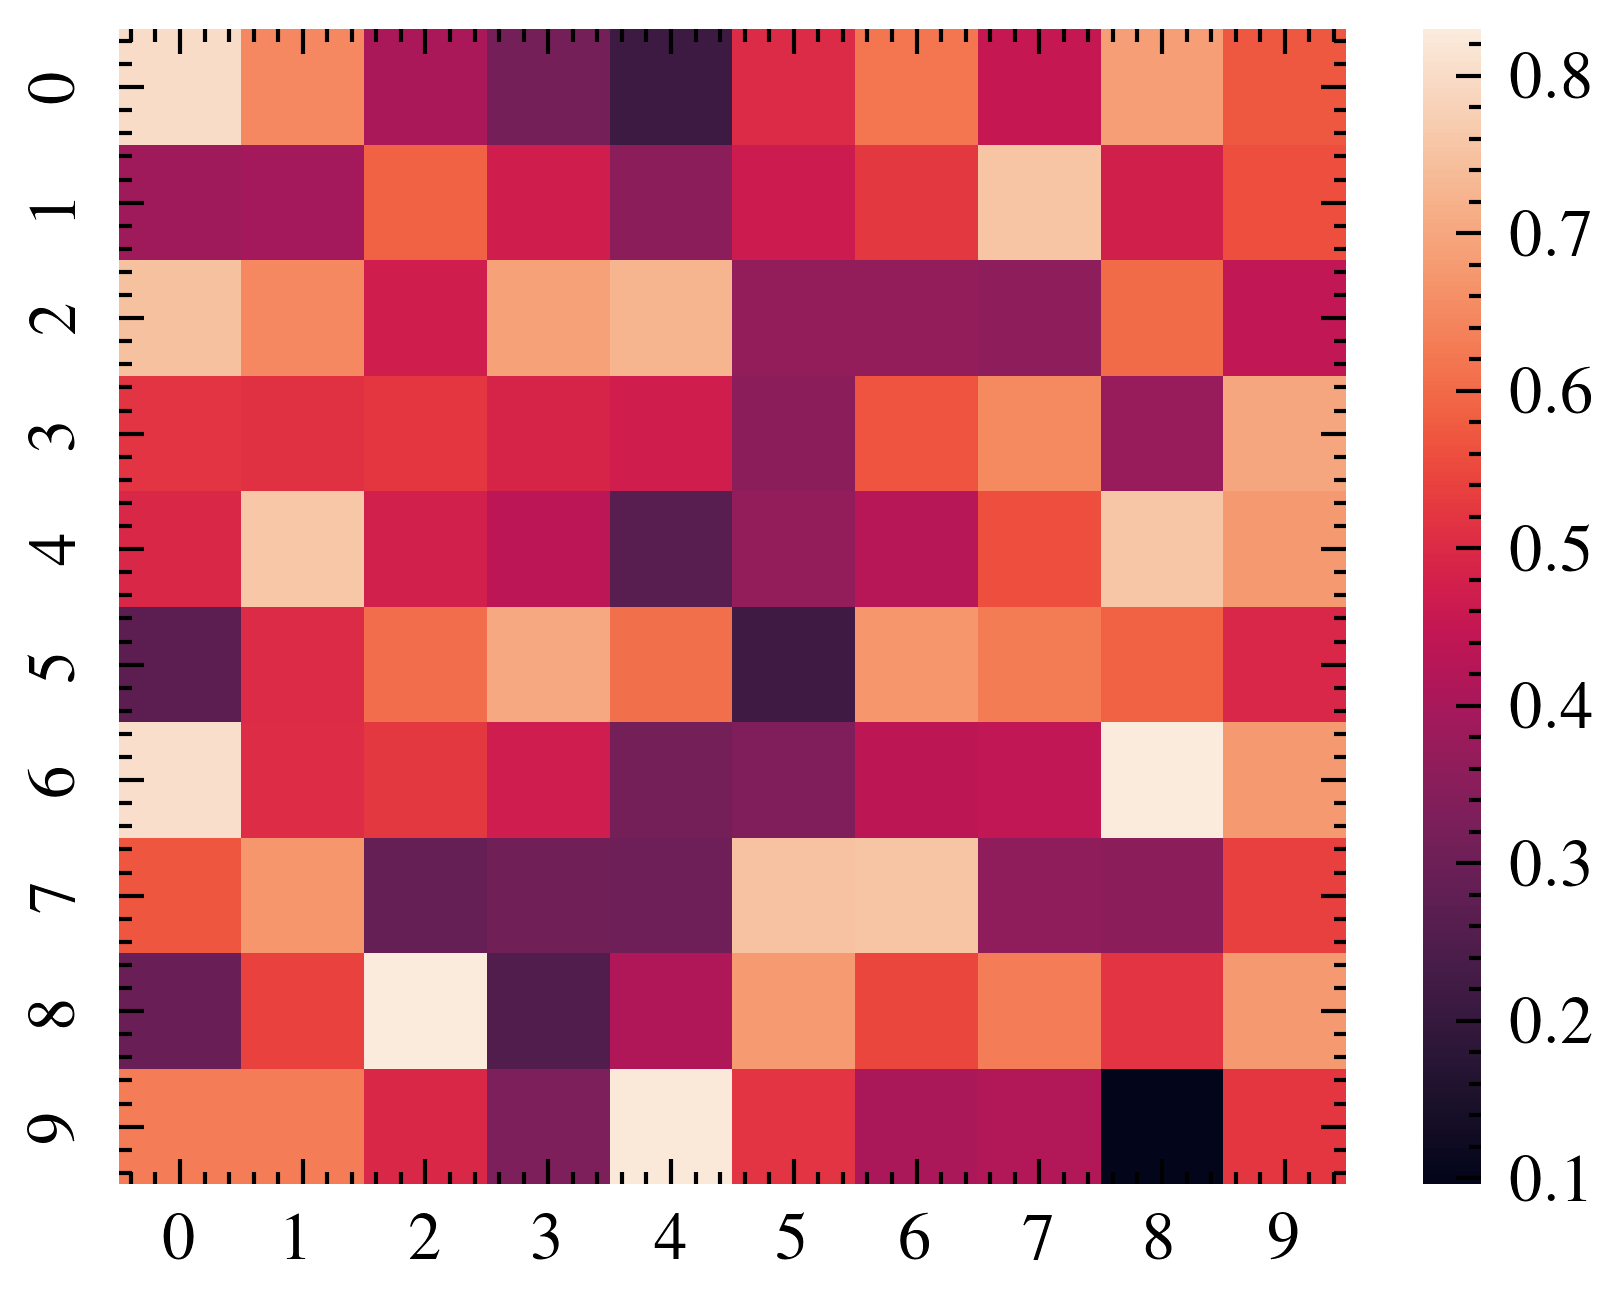

In [232]:
data_df = run_single_client_cifar100(train = False,test = True,client_idx=0,log ="logs/20221012_052431__fedavg_e10_c100" )
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])
# 
fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
# sns.barplot(x = data_df.index, y = "diff",data = data_df)
sns.heatmap(data_df["f1-score"].to_numpy().reshape((10,10)))
# plt.ylim(-0.5,0.5)
# plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()

INFO:root:train batch: 7,val batch: 3


{1: 2, 3: 28, 4: 6, 5: 15, 6: 2, 7: 3, 8: 6, 9: 21, 11: 1, 13: 25, 14: 36, 20: 22, 23: 3, 24: 2, 25: 16, 26: 3, 28: 4, 29: 1, 37: 29, 45: 10, 46: 13, 48: 1, 53: 8, 58: 81, 60: 10, 61: 2, 64: 3, 65: 1, 68: 10, 70: 1, 72: 2, 73: 2, 74: 10, 75: 14, 77: 2, 78: 18, 79: 23, 81: 1, 82: 11, 83: 13, 85: 15, 86: 1, 87: 1, 88: 27}
    precision    recall  f1-score  support  confidence      diff
0    0.687500  0.770000  0.726415    100.0    0.895695  0.208195
1    0.458065  0.710000  0.556863    100.0    0.872618  0.414553
2    0.435185  0.470000  0.451923    100.0    0.719121  0.283936
3    0.363636  0.280000  0.316384    100.0    0.554185  0.190549
4    0.376471  0.320000  0.345946    100.0    0.584755  0.208284
..        ...       ...       ...      ...         ...       ...
95   0.675676  0.500000  0.574713    100.0    0.726902  0.051226
96   0.507463  0.343434  0.409639     99.0    0.648460  0.140998
97   0.452632  0.430000  0.441026    100.0    0.656478  0.203846
98   0.315789  0.120000  0.1

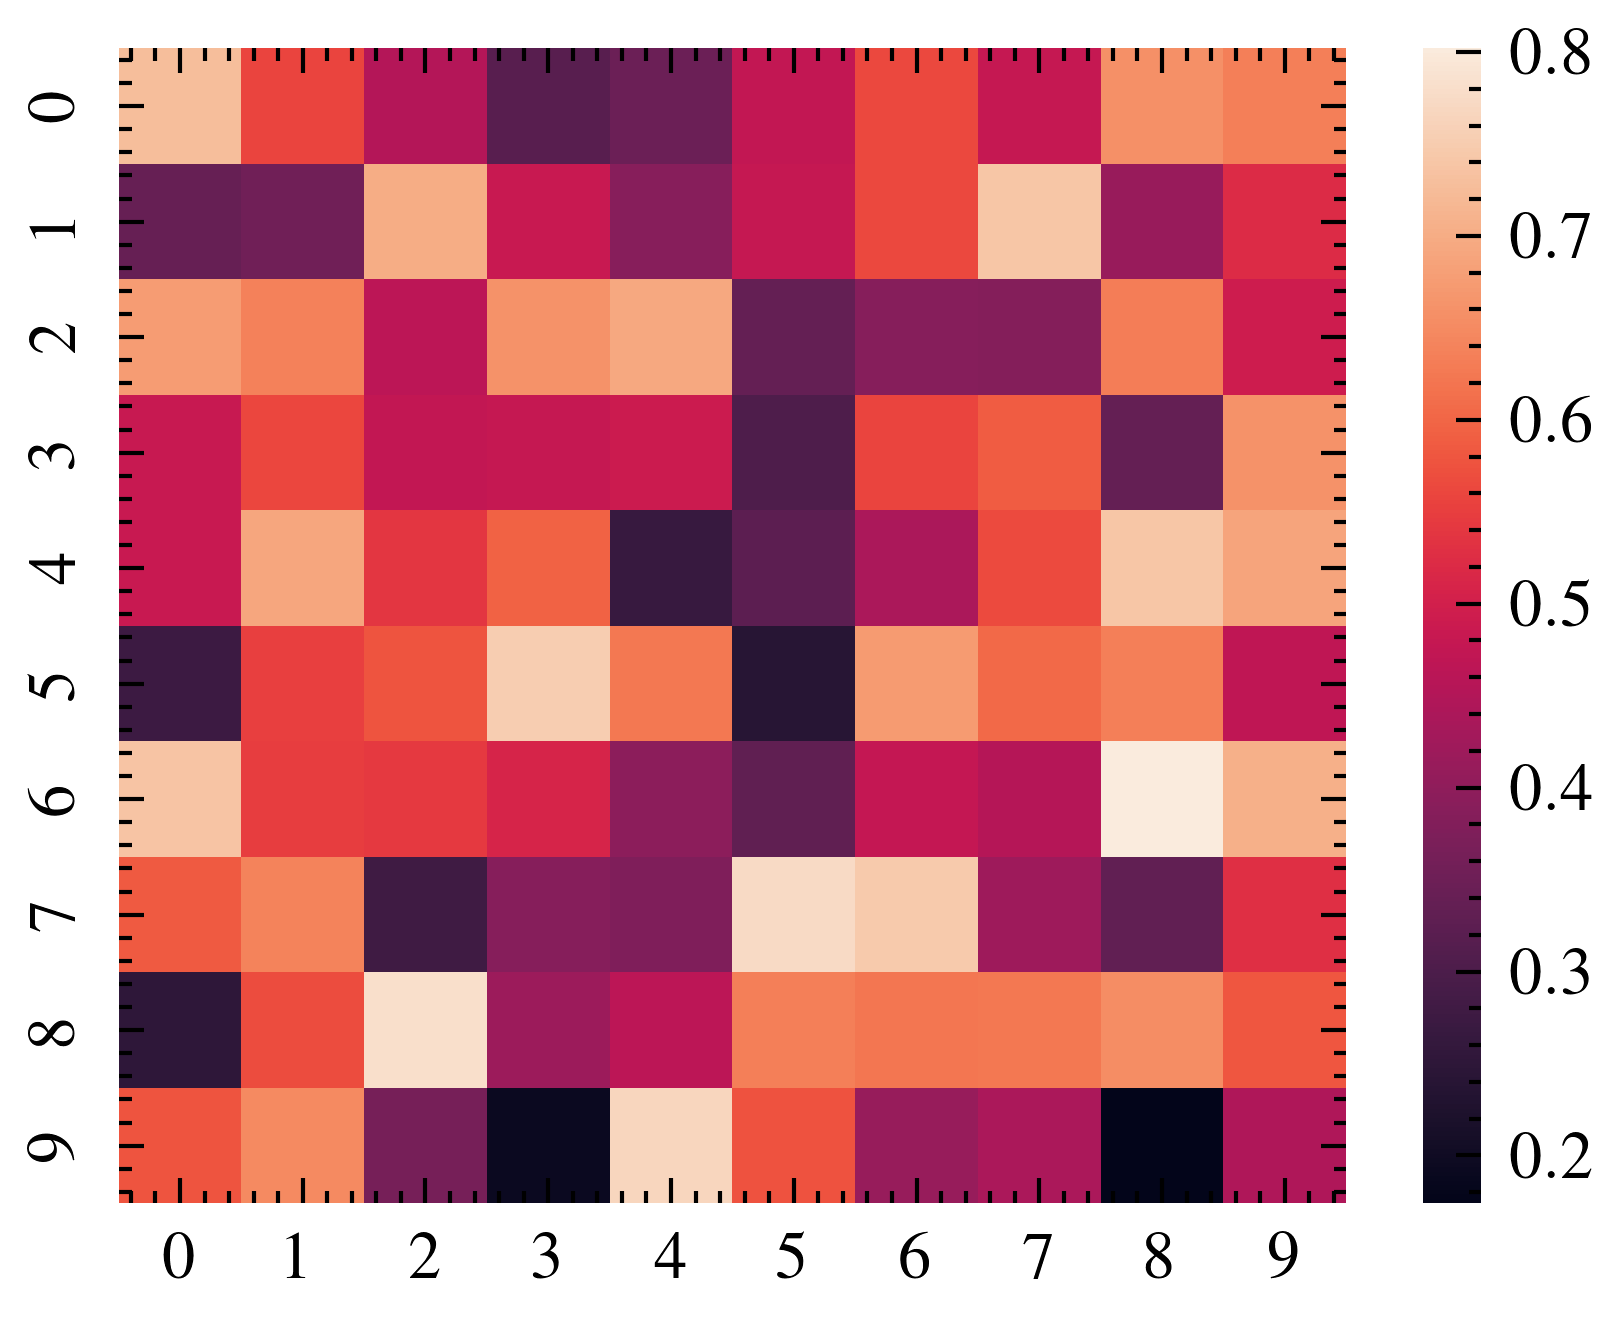

In [233]:
data_df = run_single_client_cifar100(train = False,test = True,client_idx=0,log ="logs/20221012_111327__fedbalance_e10_c100" )
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])
# 
fig, ax = plt.subplots()
ax.set_xlabel('\#Communication rounds')
ax.set_ylabel('Top-1 Accuracy(\%)')
# sns.barplot(x = data_df.index, y = "diff",data = data_df)
sns.heatmap(data_df["f1-score"].to_numpy().reshape((10,10)))
# plt.ylim(-0.5,0.5)
# plt.legend(loc="lower right",ncol= 2,fontsize=6)
# plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
plt.show()